<a href="https://colab.research.google.com/github/rohankavari/MachineLearning/blob/main/spark_Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
!ls /usr/lib/jvm/
import os
os.environ['JAVA_HOME']='/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME']='/content/spark-3.1.1-bin-hadoop2.7'
!pip install pyspark

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [8]:
import findspark
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

In [9]:
findspark.init()
spark=SparkSession.builder.master('local[*]').getOrCreate()

In [10]:
url="/content/drive/MyDrive/dataset/Real estate valuation data set.xlsx"
df=pd.read_excel("/content/drive/MyDrive/dataset/Real estate valuation data set.xlsx")
df.drop([0],inplace=True)
df.drop([113],inplace=True)
df.drop(labels=['X1'],inplace=True,axis=1)
data=spark.createDataFrame(df) 

In [11]:
data.printSchema()

root
 |-- X2: double (nullable = true)
 |-- X3: double (nullable = true)
 |-- X4: long (nullable = true)
 |-- X5: double (nullable = true)
 |-- X6: double (nullable = true)
 |-- Y: double (nullable = true)



In [12]:
data.show()

+----+--------+---+--------+---------+----+
|  X2|      X3| X4|      X5|       X6|   Y|
+----+--------+---+--------+---------+----+
|19.5|306.5947|  9|24.98034|121.53951|42.2|
|13.3|561.9845|  5|24.98746|121.54391|47.3|
|13.3|561.9845|  5|24.98746|121.54391|54.8|
| 5.0|390.5684|  5|24.97937|121.54245|43.1|
| 7.1| 2175.03|  3|24.96305|121.51254|32.1|
|34.5|623.4731|  7|24.97933|121.53642|40.3|
|20.3|287.6025|  6|24.98042|121.54228|46.7|
|31.7|5512.038|  1|24.95095|121.48458|18.8|
|17.9| 1783.18|  3|24.96731|121.51486|22.1|
|34.8|405.2134|  1|24.97349|121.53372|41.4|
| 6.3|90.45606|  9|24.97433| 121.5431|58.1|
|13.0|492.2313|  5|24.96515|121.53737|39.3|
|20.4|2469.645|  4|24.96108|121.51046|23.8|
|13.2|1164.838|  4|24.99156|121.53406|34.3|
|35.7|579.2083|  2| 24.9824|121.54619|50.5|
| 0.0|292.9978|  6|24.97744|121.54458|70.1|
|17.7|350.8515|  1|24.97544|121.53119|37.4|
|16.9|368.1363|  8| 24.9675|121.54451|42.3|
| 1.5|23.38284|  7|24.96772|121.54102|47.7|
| 4.5|2275.877|  3|24.96314|121.

functions


In [140]:
plain_result=pd.DataFrame(columns=['model','R2','MSE','MAE','RMSE'])

In [141]:
from pyspark.ml.evaluation import RegressionEvaluator
def calc_res(pred,table,cols,target):
  evaluation=RegressionEvaluator(labelCol=target,predictionCol='prediction')

  model=target+"~"+"+".join(feature_cols)
  r2=evaluation.evaluate(pred.predictions,{evaluation.metricName:"r2"})
  mse=evaluation.evaluate(pred.predictions,{evaluation.metricName:"mse"})
  mae=evaluation.evaluate(pred.predictions,{evaluation.metricName:"mae"})
  rmse=evaluation.evaluate(pred.predictions,{evaluation.metricName:"rmse"})

  data={'model':model,'R2':r2,'MSE':mse,'MAE':mae,'RMSE':rmse}
  table = table.append(data, ignore_index = True)
  return table

In [159]:
def plt_resi(pred,target='Y'):
  y=pred.predictions.select(target).toPandas()
  y_pred=pred.predictions.select('prediction').toPandas()
  e=y[target]-y_pred['prediction']
  plt.scatter(y_pred, e ,c="green")
  plt.plot([y_pred.min(), y_pred.max()], [0, 0], linewidth=2)

Model 1

In [143]:
feature_cols=data.columns[:-1]
from pyspark.ml.feature import VectorAssembler
vect_assembler=VectorAssembler(inputCols=feature_cols,outputCol='features')
final_data=vect_assembler.transform(data).select('features','Y')
final_data.show()

+--------------------+----+
|            features|   Y|
+--------------------+----+
|[19.5,306.5947,9....|42.2|
|[13.3,561.9845,5....|47.3|
|[13.3,561.9845,5....|54.8|
|[5.0,390.5684,5.0...|43.1|
|[7.1,2175.03,3.0,...|32.1|
|[34.5,623.4731,7....|40.3|
|[20.3,287.6025,6....|46.7|
|[31.7,5512.038,1....|18.8|
|[17.9,1783.18,3.0...|22.1|
|[34.8,405.2134,1....|41.4|
|[6.3,90.45606,9.0...|58.1|
|[13.0,492.2313,5....|39.3|
|[20.4,2469.645,4....|23.8|
|[13.2,1164.838,4....|34.3|
|[35.7,579.2083,2....|50.5|
|[0.0,292.9978,6.0...|70.1|
|[17.7,350.8515,1....|37.4|
|[16.9,368.1363,8....|42.3|
|[1.5,23.38284,7.0...|47.7|
|[4.5,2275.877,3.0...|29.3|
+--------------------+----+
only showing top 20 rows



In [144]:
from pyspark.ml.regression import LinearRegression
linreg=LinearRegression(featuresCol='features',labelCol='Y')
model=linreg.fit(final_data)
pred=model.evaluate(final_data)

In [145]:
pred.predictions.show()

+--------------------+----+------------------+
|            features|   Y|        prediction|
+--------------------+----+------------------+
|[19.5,306.5947,9....|42.2| 49.67606299151521|
|[13.3,561.9845,5....|47.3| 46.57235486740501|
|[13.3,561.9845,5....|54.8| 46.57235486740501|
|[5.0,390.5684,5.0...|43.1| 47.52657800428824|
|[7.1,2175.03,3.0,...|32.1|33.351202249730704|
|[34.5,623.4731,7....|40.3| 41.59969026329236|
|[20.3,287.6025,6....|46.7| 45.53837536269657|
|[31.7,5512.038,1....|18.8| 8.461156761405618|
|[17.9,1783.18,3.0...|22.1|33.029495628180484|
|[34.8,405.2134,1....|41.4|32.852619917683114|
|[6.3,90.45606,9.0...|58.1| 52.62305338004626|
|[13.0,492.2313,5....|39.3| 41.78334180756974|
|[20.4,2469.645,4....|23.8|29.667794783019417|
|[13.2,1164.838,4....|34.3| 43.72073092755818|
|[35.7,579.2083,2....|50.5| 35.53385370603428|
|[0.0,292.9978,6.0...|70.1|50.148867382384196|
|[17.7,350.8515,1....|37.4| 37.88654024589596|
|[16.9,368.1363,8....|42.3|45.957963399923756|
|[1.5,23.3828

In [146]:
plain_result=calc_res(pred,plain_result,feature_cols,"Y")
plain_result

,model,R2,MSE,MAE,RMSE
0,Y~X2+X3+X4+X5+X6,0.630971,62.141516,5.934685,7.882989


Reseduals

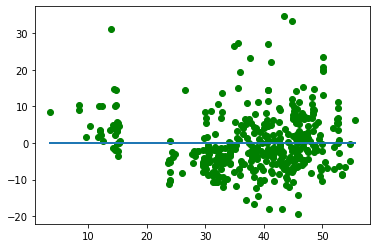

In [147]:
plt_resi(pred)

Model2

In [148]:
from pyspark.sql.functions import log
from pyspark.sql import functions 
a=data.withColumn("logX2",log(col("X2")))
a=a.na.drop()

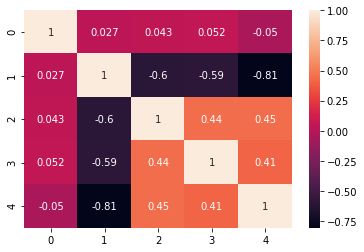

In [149]:
from pyspark.ml.stat import Correlation
import seaborn as sns
cor=Correlation.corr(final_data,"features").collect()[0][0].toArray()
sns.heatmap(cor,annot=True)

In [150]:
feature_cols=['X2', 'X3', 'X4', 'X5', 'X6', 'logX2']
from pyspark.ml.feature import VectorAssembler
vect_assembler=VectorAssembler(inputCols=feature_cols,outputCol='features')
final_data=vect_assembler.transform(a).select("features",'Y')
final_data.show()

+--------------------+----+
|            features|   Y|
+--------------------+----+
|[19.5,306.5947,9....|42.2|
|[13.3,561.9845,5....|47.3|
|[13.3,561.9845,5....|54.8|
|[5.0,390.5684,5.0...|43.1|
|[7.1,2175.03,3.0,...|32.1|
|[34.5,623.4731,7....|40.3|
|[20.3,287.6025,6....|46.7|
|[31.7,5512.038,1....|18.8|
|[17.9,1783.18,3.0...|22.1|
|[34.8,405.2134,1....|41.4|
|[6.3,90.45606,9.0...|58.1|
|[13.0,492.2313,5....|39.3|
|[20.4,2469.645,4....|23.8|
|[13.2,1164.838,4....|34.3|
|[35.7,579.2083,2....|50.5|
|[17.7,350.8515,1....|37.4|
|[16.9,368.1363,8....|42.3|
|[1.5,23.38284,7.0...|47.7|
|[4.5,2275.877,3.0...|29.3|
|[10.5,279.1726,7....|51.6|
+--------------------+----+
only showing top 20 rows



In [151]:
from pyspark.ml.regression import LinearRegression
linreg=LinearRegression(featuresCol='features',labelCol='Y')
model=linreg.fit(final_data)
pred=model.evaluate(final_data)
plain_result=calc_res(pred,plain_result,feature_cols,"Y")
plain_result

,model,R2,MSE,MAE,RMSE
0,Y~X2+X3+X4+X5+X6,0.630971,62.141516,5.934685,7.882989
1,Y~X2+X3+X4+X5+X6+logX2,0.647876,55.821528,5.634257,7.471381


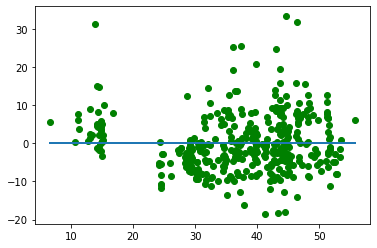

In [152]:
plt_resi(pred)

Model 3

In [153]:
a=data.withColumn("logY",log(col("Y")))
a=a.withColumn("logX2",log(col("X2")))
a=a.na.drop()

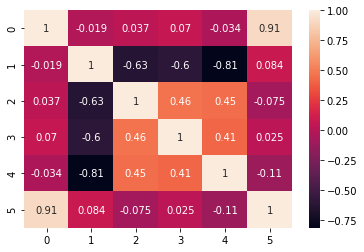

In [154]:
cor=Correlation.corr(final_data,"features").collect()[0][0].toArray()
sns.heatmap(cor,annot=True)

In [155]:
feature_cols=['X4', 'X5', 'X6', 'logX2']
from pyspark.ml.feature import VectorAssembler
vect_assembler=VectorAssembler(inputCols=feature_cols,outputCol='features')
final_data=vect_assembler.transform(a).select("features",'logY')
final_data.show()

+--------------------+------------------+
|            features|              logY|
+--------------------+------------------+
|[9.0,24.98034,121...| 3.742420221041966|
|[5.0,24.98746,121...| 3.856510295497887|
|[5.0,24.98746,121...|  4.00369019395397|
|[5.0,24.97937,121...| 3.763522997109702|
|[3.0,24.96305,121...|3.4688560301359703|
|[7.0,24.97933,121...| 3.696351468952637|
|[6.0,24.98042,121...|3.8437441646748516|
|[1.0,24.95095,121...|2.9338568698359033|
|[3.0,24.96731,121...|3.0955776085237074|
|[1.0,24.97349,121...|3.7232808808312687|
|[9.0,24.97433,121...| 4.062165663857866|
|[5.0,24.96515,121...|3.6712245188752153|
|[4.0,24.96108,121...| 3.169685580677429|
|[4.0,24.99156,121...| 3.535145354171894|
|[2.0,24.9824,121....|3.9219733362813143|
|[1.0,24.97544,121...|3.6216707044204863|
|[8.0,24.9675,121....| 3.744787086052232|
|[7.0,24.96772,121...|3.8649313978942956|
|[3.0,24.96314,121...|3.3775875160230218|
|[7.0,24.97528,121...|3.9435216724875173|
+--------------------+------------

In [156]:
from pyspark.ml.regression import LinearRegression
linreg=LinearRegression(featuresCol='features',labelCol='logY')
model=linreg.fit(final_data)
pred=model.evaluate(final_data)
plain_result=calc_res(pred,plain_result,feature_cols,"logY")
plain_result

,model,R2,MSE,MAE,RMSE
0,Y~X2+X3+X4+X5+X6,0.630971,62.141516,5.934685,7.882989
1,Y~X2+X3+X4+X5+X6+logX2,0.647876,55.821528,5.634257,7.471381
2,logY~X4+X5+X6+logX2,0.693531,0.043746,0.159779,0.209156


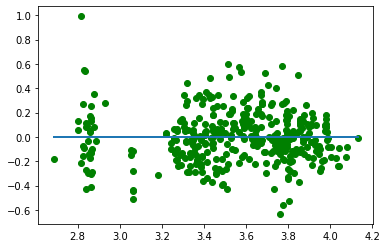

In [160]:
plt_resi(pred,'logY')